Lets consider an online game which contains gates that force the users to wait a non-trivial amount of time or make an in-app purchase to progress. Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in the game from level 30 to level 40. In particular, we will look at the impact on player retention.

In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## The AB-test data

The data we have is from 90,189 players that installed the game while the AB-test was running.

userid - a unique number that identifies each player.

version- whether the player was put in the control group 

gate_30- a gate at level 30 (control group)

gate_40 - a gate at level 40 (treatment group)

sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.

retention_1- did the player come back and play 1 day after installing?

retention_7- did the player come back and play 7 days after installing?


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. 

As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [4]:
# Counting the number of players in each AB group.
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


looks like there is roughly the same number of players in each group

## The distribution of game rounds

Now, let's plot the distribution of the number of game rounds players played during their first week playing the game.

Text(0, 0.5, 'User Count')

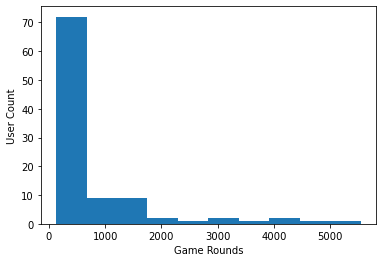

In [5]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count().sort_values(ascending=False)

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(kind='hist', x='sum_gamerounds', y='userid')
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked. Now, lets see how the 1 day retention of these players is looking like at an overall level.

## Overall 1-day retention

In [6]:
# The % of users that came back the day after they installed
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups

In [7]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum()/df.groupby('version')['retention_1'].count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## Confidence in the difference in 1-day retention

There are a couple of ways we can get at the certainty of these retention numbers; 

a) Bootstrapping: where we  will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

b) using t test to calculate the p-value of the difference between the test and control groups for 1-day retention.

#### a) Bootstrapping (1 day retention)

<AxesSubplot:ylabel='Density'>

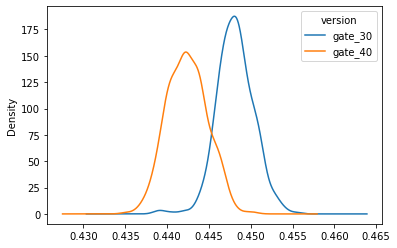

In [9]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot.kde()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention

Text(0.5, 0, '% difference in means')

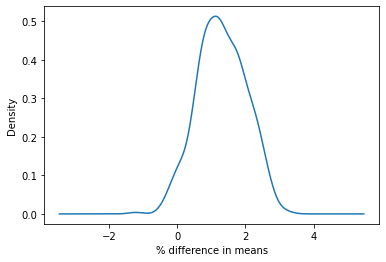

In [10]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])*100/boot_1d['gate_40']

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [11]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum()/len(boot_1d['diff']) 

# Pretty printing the probability
print("{:.2%}".format(prob))

96.60%


#### b) t test (1 day retention)

Either of bootstrapping or t-test would also work. But here, let's confirm the above observed difference statistically using a t-test.

In [12]:
from scipy.stats import ttest_ind

In [14]:
# Calculate t-statistic and p-value
t_stat, p_val = ttest_ind(df[df['version'] == 'gate_30']['retention_1'],
                          df[df['version'] == 'gate_40']['retention_1'])

In [15]:
# Print the t-statistic and p-value
print("t-statistic: {:.2f}, p-value: {:.2f}".format(t_stat, p_val))

t-statistic: 1.78, p-value: 0.07


In [16]:
# Check if the p-value is less than 0.05 (assuming a significance level of 0.05)
if p_val < 0.05:
    print("There is a significant difference between the means of the two AB groups.")
else:
    print("There is no significant difference between the means of the two AB groups.")

There is no significant difference between the means of the two AB groups.


## 7-day retention by AB-group

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

So, let's also look at the 7 day retention rates for both test and control groups.

In [17]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum()/df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Even in 7-day retention gate_40 (test group) is slightly lower (18.2%) than gate_30 (19.0%). This difference is also larger than for 1-day retention, mostly because more players have had reached the first gate. 

Let's proceed to do the bootstrapping and t-test for 7-day retention as well.

#### a) Bootstrapping (7 day retention)

100.00%


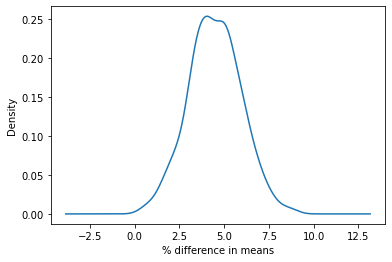

In [18]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30']-boot_7d['gate_40'])*100/boot_7d['gate_40']

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print("{:.2%}".format(prob))

#### b) t test (7 day retention)

In [19]:
# Calculate t-statistic and p-value
t_stat, p_val = ttest_ind(df[df['version'] == 'gate_30']['retention_7'],
                          df[df['version'] == 'gate_40']['retention_7'])

In [20]:
# Print the t-statistic and p-value
print("t-statistic: {:.2f}, p-value: {:.2f}".format(t_stat, p_val))

t-statistic: 3.16, p-value: 0.00


In [21]:
# Check if the p-value is less than 0.05 (assuming a significance level of 0.05)
if p_val < 0.05:
    print("There is a significant difference between the means of the two AB groups.")
else:
    print("There is no significant difference between the means of the two AB groups.")

There is a significant difference between the means of the two AB groups.


## Conclusion

The AB-test shows that the gate at level 40 is slightly worse than the gate at level 30. This is true for both 1-day and 7-day retention. The difference is small, but statistically significant and also this difference in reality is considerable. But the results are only conclusive if the A/B test was run correctly accounting for all the confounding factors.

One more thing to note is that the retention rate for 7 day retention is higher than 1 day retention. This could be  because the 7 day retention is calculated for players who have played the game for at least 1 day. So, the 7 day retention is a subset of 1 day retention. One more reason for this could also be the hedonic adaptation which is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.